# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# Proyecto 02
## Cancelación Activa de Ruido
Este trabajo desarrolla la síntesis de un sistema de cancelación activa de ruido basado en el algoritmo RLS, utilizando un enfoque donde sólo se busca modelar (de forma adaptativa) el camino acústico primario $P(z)$.

#### Grupo N° 1
* DAVIDOV, Gonzalo Joaquín
* FARALL, Facundo David
* KAMMANN, Lucas Agustín
* TROZZO, Rafael Nicolás

In [1]:
import importlib

In [2]:
import test_model
importlib.reload(test_model);

In [3]:
import anc_complete
importlib.reload(anc_complete);

In [4]:
import plot_helpers
importlib.reload(plot_helpers);

In [5]:
import boseqc20_model
importlib.reload(boseqc20_model);

In [6]:
import lms_complete
importlib.reload(lms_complete);

In [7]:
import numpy as np

In [8]:
from librosa import load

C:\Users\facun\Anaconda3\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\facun\Anaconda3\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [9]:
subway_noise = [np.array(load("../support/samples/subway.wav", sr=48e3)[0], dtype=float), "Subway"]

# Comparación de tiempos de convergencia entre FX-BRLS, FX-RRLS y FX-NLMS 

In [10]:
N = 48_000 * 5 # Quantity of samples used for the simulation  
x = np.random.normal(size=N) # Gaussian white noise

Primero con FX-NLMS

In [11]:
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x) # Load the noise samples for the simulation
headphone.reset() # Reset the time instant

In [12]:
order = 200
step = 0.0005
e_lms, w_lms = lms_complete.anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=None)

Luego con FX-BRLS

In [18]:
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x) # Load the noise samples for the simulation
headphone.reset() # Reset the time instant

In [19]:
forget = 0.1
order = 200
e_rls, w_rls = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=np.var(x) * (1 - forget), force_hermitian=True)

Took 0.0008863900909821191 seconds
Propagation: 41.6 %
Algorithm: 56.52 %
Update: 1.88 %


Finalmente con FX-RRLS

In [ ]:
# Aca iria FX-RRLS 

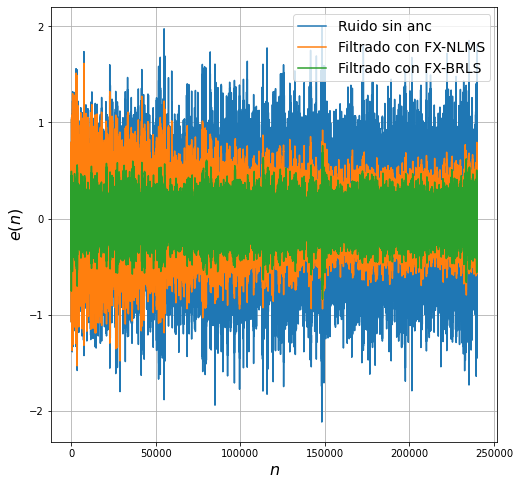

In [20]:
# Plot the ANC results
plot_helpers.plot_anc_results([headphone.d, e_lms, e_rls], None, labels = ['Ruido sin ANC','Filtrado con FX-NLMS', 'Filtrado con FX-BRLS'])

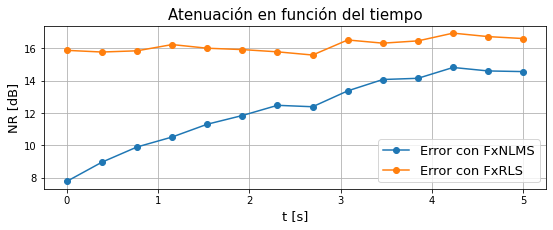

In [21]:
plot_helpers.plot_error_evolution(x, [e_lms, e_rls], 8192*2, 0, 48e3, labels=["Error con FxNLMS", "Error con FxRLS"])

Se puede apreciar una diferencia notable en los tiempos de convergencia entre cada algoritmo, para llegar a la atenuación que RLS adquiere casi instantaneamente, LMS tarda aproximadamente 3s.

## Comparación de la adaptación ante la variación de P (Camino primario)
Para validar el funcionamiento y justificar el uso de un filtro LMS adaptativo, se prueba una situación más cercana a una aplicación real, donde P(z) cambia en el tiempo. En la siguiente prueba, en $t=5s$ se cambian los coeficientes de P entre la primera y la tercera medición de la base de datos y se observa la adaptación del filtro. Nota: Se usan estas mediciones porque se vio que cambiaban un poco, la primera y segunda eran bastante parecidas.

Primero con FX-NLMS, tanto para el mejor caso, M=3000, como para el mismo orden a usar en los algoritmos con RLS, M=200

In [10]:
N = -1
x = subway_noise[0][:N]
x /= x.max()

# Frequency responses change setup
# Measurement indexes to be used
indexes = [0, 2]
prim_paths = []
sec_paths = []

# Create the simulated headphone and the test noise
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x)

In [11]:
# Algorithm parameters
order = 3000
step = 0.0005
w_lms = np.zeros(order)
error_lms_3000 = []
weights_lms_3000 = []

for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Save responses 
    prim_paths.append(headphone.p)
    sec_paths.append(headphone.g)

    # Run the algorithm
    aux_err, w_lms = lms_complete.anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=w_lms)

    # Save weights and error
    weights_lms_3000.append(np.array(w_lms))
    error_lms_3000 = np.concatenate([error_lms_3000, aux_err])

In [12]:
x = subway_noise[0][:N]
x /= x.max()

# Frequency responses change setup
# Measurement indexes to be used
indexes = [0, 2]
prim_paths = []
sec_paths = []

# Create the simulated headphone and the test noise
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x)

In [13]:
# Algorithm parameters
order = 200
step = 0.0005
w_lms = np.zeros(order)
error_lms_200 = []
weights_lms_200 = []

for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Save responses 
    prim_paths.append(headphone.p)
    sec_paths.append(headphone.g)

    # Run the algorithm
    aux_err, w_lms = lms_complete.anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=w_lms)

    # Save weights and error
    weights_lms_200.append(np.array(w_lms))
    error_lms_200 = np.concatenate([error_lms_200, aux_err])

Luego con FX-BRLS

In [14]:
x = subway_noise[0][:N]
x /= x.max()

# Frequency responses change setup
# Measurement indexes to be used
indexes = [0, 2]
prim_paths = []
sec_paths = []

# Create the simulated headphone and the test noise
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x)

Se agregó una condición que ante el caso de que el error "explote" en RLS, se reinicia la matriz P con los valores de delta para acelerar su convergencia nuevamente.

In [15]:
# Algorithm parameters
forget = 0.02
order = 200
error_brls = []
weights_brls = []

for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Save responses 
    prim_paths.append(headphone.p)
    sec_paths.append(headphone.g)

    # Run the algorithm
    aux_err, w_rls = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=np.var(x) * (1 - forget), force_hermitian=True, reset_type="static")

    # Save weights_rls and error
    weights_brls.append(np.array(w_rls))
    error_brls = np.concatenate([error_brls, aux_err])

Took 360.40525007247925 seconds
Propagation: 28.773 %
Algorithm: 69.853 %
Update: 1.375 %
Took 375.5284309387207 seconds
Propagation: 28.769 %
Algorithm: 69.894 %
Update: 1.337 %


Finalmente, con FX-RRLS

In [16]:
x = subway_noise[0][:N]
x /= x.max()

# Frequency responses change setup
# Measurement indexes to be used
indexes = [0, 2]
prim_paths = []
sec_paths = []

# Create the simulated headphone and the test noise
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x)

In [17]:
# Algorithm parameters
forget = 0.999
order = 200
error_rrls = []
weights_rrls = []

for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Save responses 
    prim_paths.append(headphone.p)
    sec_paths.append(headphone.g)

    # Run the algorithm
    aux_err, w_rls = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=50, force_hermitian=True, p_normalization=False, reset_type="var")

    # Save weights_rls and error
    weights_rrls.append(np.array(w_rls))
    error_rrls = np.concatenate([error_rrls, aux_err])

Took 319.02161836624146 seconds
Propagation: 28.401 %
Algorithm: 70.269 %
Update: 1.33 %
Took 309.65393018722534 seconds
Propagation: 27.841 %
Algorithm: 70.708 %
Update: 1.451 %


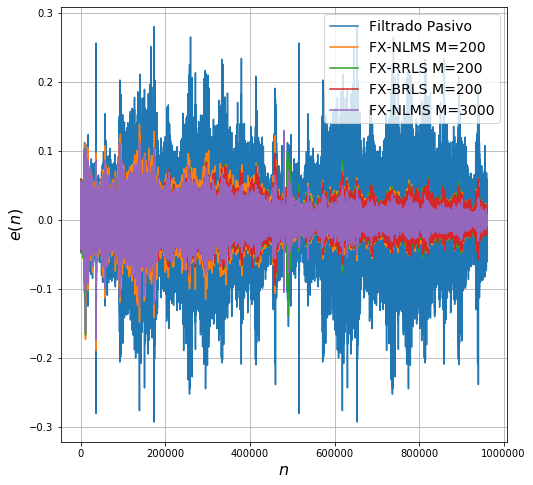

In [25]:
# Plot the ANC results
plot_helpers.plot_anc_results([np.concatenate([headphone.d,headphone.d]), error_lms_200, error_rrls, error_brls, error_lms_3000], labels=["Filtrado Pasivo", "FX-NLMS M=200", "FX-RRLS M=200", "FX-BRLS M=200", "FX-NLMS M=3000"])

Este grafico de arriba no lo incluiria en el informe, no suma mucho, es mas claro el de abajo.

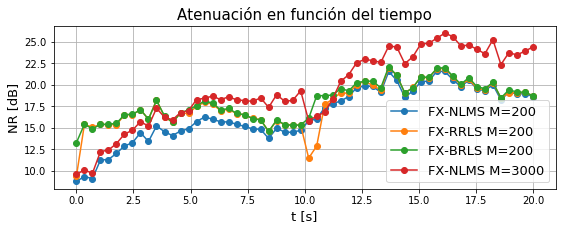

In [28]:
plot_helpers.plot_error_evolution(np.concatenate([x,x]), [error_lms_200, error_rrls, error_brls, error_lms_3000], 8192 * 2, 0, 48e3, labels=["FX-NLMS M=200", "FX-RRLS M=200", "FX-BRLS M=200", "FX-NLMS M=3000"])

* El que mejor ajusta al final es NLMS con M=3000, claramente importa el orden
* De las variantes estudiadas, BRLS converge mucho mas rapido
* Es posible que los metaparametros de RRLS puedan ser ajustados

In [20]:
plot_helpers.plot_frequency_responses(prim_paths, sec_paths, [weights_lms, weights_rls], 48_000, labels=["W de FxNLMS", "W de FxRLS"])

NameError: name 'weights_lms' is not defined

## Comparación entre los tiempos de ejecución

In [ ]:
import time

In [ ]:
N = 1000

# Lists for elapsed times
lms_times = []
rls_times = []

for i in range(1, 11):
# Create the simulated headphone and the test noise
    headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, order=2000)
    x_white = np.random.normal(size=N * i)
    headphone.set_noise(x_white)

    # LMS parameters
    order = 3000
    step = 0.004
    w_lms = np.zeros(order)

    # Run LMS
    start_time = time.time()
    lms_complete.anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=w_lms)
    lms_times.append(time.time() - start_time)

    headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, order=2000)
    x_white = np.random.normal(size=N * i)
    headphone.set_noise(x_white)
    
    # RLS parameters
    forget = 0.05
    order = 200

    # Run RLS
    start_time = time.time()
    anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=np.var(x_white) * (1 - forget), force_hermitian=True)
    rls_times.append(time.time() - start_time)

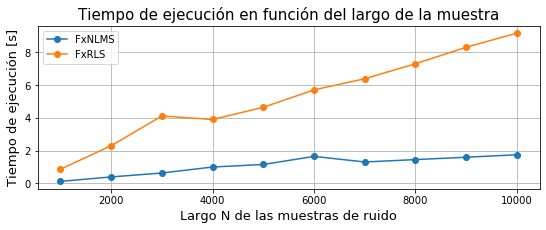

In [ ]:
plot_helpers.plot_execution_times([lms_times, rls_times], N * np.array(range(1, 11)), ["FxNLMS", "FxRLS"])

In [ ]:
print(f"El tiempo máximo de ejecución de FxNLMS es de {max(lms_times):.2f}s mientras que para FxRLS es de {max(rls_times):.2f}")

El tiempo máximo de ejecución de FxNLMS es de 1.75s mientras que para FxRLS es de 9.17


# Comparación al agregarle ruido de medición
A continuación se evalua que sucede con RLS y LMS al agregarle ruido de medición. Se prueba con 3 SNRs distintos y se grafica la atenuación en función del tiempo comparando los tiempos de convergencia de ambos.

In [19]:
N = 48_000 * 3 # Quantity of samples used for the simulation  
x = np.random.normal(size=N) # Gaussian white noise

In [20]:
#Let's create an array of different SNR's
SNRs = [20, 40, 60]

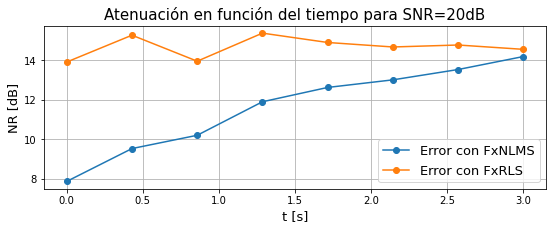

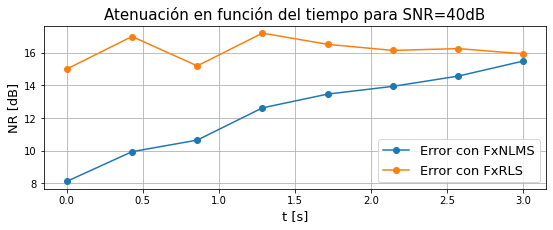

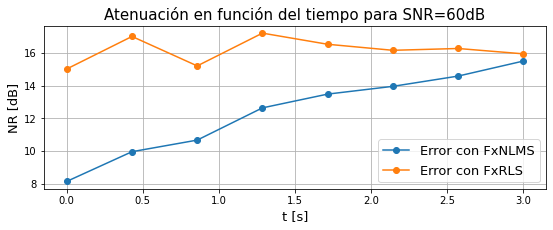

In [21]:
for snr in SNRs:
    headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000, snr=snr)
    headphone.set_noise(x) # Load the noise samples for the simulation
    headphone.reset() # Reset the time instant
    order = 3000
    step = 0.0005
    e_lms, w_lms = lms_complete.anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=None)

    headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000, snr=snr)
    headphone.set_noise(x) # Load the noise samples for the simulation
    headphone.reset() # Reset the time instant
    forget = 0.1
    order = 200
    e_rls, w_rls = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=np.var(x) * (1 - forget), force_hermitian=True)
    plot_helpers.plot_error_evolution(x, [e_lms, e_rls], 8192*2, 0, 48e3, labels=["Error con FxNLMS", "Error con FxRLS"], title = f'Atenuación en función del tiempo para SNR={snr}dB')

Se puede observar que agregarle ruido al micrófono de error no modifica, o modifica muy levemente, la respuesta de los sistemas planteados. 